In [1]:
import numpy as np
import pandas as pd
import imageio
import os
import subprocess
from multiprocessing import Pool
from itertools import cycle
import warnings
import glob
import time
from tqdm import tqdm
from util import save
from argparse import ArgumentParser
from skimage import img_as_ubyte
from skimage.transform import resize
from AudioConfig import AudioConfig
warnings.filterwarnings("ignore")

DEVNULL = open(os.devnull, 'wb')
DEVDEBUG = open('debug.log', 'w')

def download(video_id, args):
    video_path = os.path.join(args.video_folder, video_id + ".mp4")
    subprocess.call([args.youtube, '-f', "''best/mp4''", '--write-auto-sub', '--write-sub',
                     '--sub-lang', 'en', '--skip-unavailable-fragments',
                     "https://www.youtube.com/watch?v=" + video_id, "--output",
                     video_path], stdout=DEVDEBUG, stderr=DEVDEBUG)
    return video_path

In [2]:
parser = ArgumentParser()
parser.add_argument(
    "--video_folder", default='vox_raw', help='Path to youtube videos')
parser.add_argument(
    "--metadata", default='vox-metadata.csv', help='Path to metadata')
parser.add_argument("--out_folder", default='vox',
                    help='Path to output')
parser.add_argument("--format", default='.png', help='Storing format')
parser.add_argument("--workers", default=1, type=int,
                    help='Number of workers')
parser.add_argument("--youtube", default='./youtube-dl',
                    help='Path to youtube-dl')
parser.add_argument("--audio", action='store_true',
                    help='extract audio and get melspectogram')

parser.add_argument("--image_shape", default=(256, 256), type=lambda x: tuple(map(int, x.split(','))),
                    help="Image shape, None for no resize")

args = parser.parse_args('--audio'.split())
print(args)

Namespace(audio=True, format='.png', image_shape=(256, 256), metadata='vox-metadata.csv', out_folder='vox', video_folder='vox_raw', workers=1, youtube='./youtube-dl')


In [3]:
if not os.path.exists(args.video_folder):
    os.makedirs(args.video_folder)
if not os.path.exists(args.out_folder):
    os.makedirs(args.out_folder)
for partition in ['test', 'train']:
    if not os.path.exists(os.path.join(args.out_folder, partition)):
        os.makedirs(os.path.join(args.out_folder, partition))

df = pd.read_csv(args.metadata)
video_ids = set(df['video_id'])

In [4]:
video_id = next(cycle(video_ids))
print(video_id)

rGWIzHtlB6M


In [7]:
if not os.path.exists(args.video_folder):
    os.makedirs(args.video_folder)

In [5]:
if not os.path.exists(os.path.join(args.video_folder, video_id.split('#')[0] + '.mp4')):
    download(video_id.split('#')[0], args)

if not os.path.exists(os.path.join(args.video_folder, video_id.split('#')[0] + '.mp4')):
    print('Can not load video %s, broken link' % video_id.split('#')[0])

In [20]:
import shutil

shutil.rmtree(args.out_folder)
if not os.path.exists(args.out_folder):
    os.makedirs(args.out_folder)
for partition in ['test', 'train']:
    if not os.path.exists(os.path.join(args.out_folder, partition)):
        os.makedirs(os.path.join(args.out_folder, partition))

In [29]:
import torch
import torchaudio
from typing import Tuple

def get_mel_spectrogram(audio_path: str, fps: float) -> Tuple[torch.tensor, int]:
    waveform, sample_rate = torchaudio.load(audio_path)
    hop_length = int(sample_rate / fps)
    n_fft = hop_length * 2
    print(f'[DEBUG] hop_length: {hop_length}, n_fft: {n_fft}')
    get_specs = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        f_max=16000,
        hop_length=hop_length,
        n_fft=n_fft
    )
    mel_spec = get_specs(waveform)
    return mel_spec, sample_rate

raw_path = os.path.join(args.video_folder, video_id.split('#')[0] + '.mp4')
reader = imageio.get_reader(raw_path)
fps = reader.get_meta_data()['fps']

df = pd.read_csv(args.metadata)
df = df[df['video_id'] == video_id]

all_chunks_dict = [{'start': df['start'].iloc[j], 'end': df['end'].iloc[j],
                    'bbox': list(map(int, df['bbox'].iloc[j].split('-'))), 'frames':[]} for j in range(df.shape[0])]
ref_fps = df['fps'].iloc[0]
ref_height = df['height'].iloc[0]
ref_width = df['width'].iloc[0]
partition = df['partition'].iloc[0]
try:
    for i, frame in enumerate(reader):
        for entry in all_chunks_dict:
            if (i * ref_fps >= entry['start'] * fps) and (i * ref_fps < entry['end'] * fps):
                left, top, right, bot = entry['bbox']
                left = int(left / (ref_width / frame.shape[1]))
                top = int(top / (ref_height / frame.shape[0]))
                right = int(right / (ref_width / frame.shape[1]))
                bot = int(bot / (ref_height / frame.shape[0]))
                crop = frame[top:bot, left:right]
                if args.image_shape is not None:
                    crop = img_as_ubyte(
                        resize(crop, args.image_shape, anti_aliasing=True))
                entry['frames'].append(crop)
except imageio.core.format.CannotReadFrameError:
    None

for entry in all_chunks_dict:
    if 'person_id' in df:
        first_part = df['person_id'].iloc[0] + "#"
    else:
        first_part = ""
    first_part = first_part + '#'.join(video_id.split('#')[::-1])
    path = first_part + '#' + \
        str(entry['start']).zfill(6) + '#' + \
        str(entry['end']).zfill(6) + '.mp4'
    mp4_path = os.path.join(args.out_folder, partition, path)
    save(mp4_path, entry['frames'], args.format)
    if args.audio:
        start = entry["start"] / ref_fps
        duration = (entry["end"] - entry["start"]) / ref_fps
        # mp3
        path = first_part + '#' + \
            str(entry['start']).zfill(6) + '#' + \
            str(entry['end']).zfill(6) + '.mp3'
        mp3_path = os.path.join(args.out_folder, partition, path)
        command = f'ffmpeg -ss {start} -t {duration} -i {raw_path} -q:a 0 -map a {mp3_path}'
        subprocess.call(command.split(' '), stdout=DEVDEBUG, stderr=DEVDEBUG)
        # melspectogram
        spec, sr = get_mel_spectrogram(mp3_path, fps)
        spec = spec[0, :, :frame_cnt]
        path = first_part + '#' + \
            str(entry['start']).zfill(6) + '#' + \
            str(entry['end']).zfill(6) + '.npy'
        spec_path = os.path.join(args.out_folder, partition, path)
        torch.save(spec, spec_path)
        # TODO: Remove debug code
        frame_cnt = len(entry['frames'])
        print(f'frame_cnt: {frame_cnt}, ref_fps({ref_fps}) x duration({duration}) = {ref_fps * duration}, spectogram: {spec.shape}')
    break

[DEBUG] hop_length: 1471, n_fft: 2942
frame_cnt: 343, ref_fps(25) x duration(11.44) = 286.0, spectogram: torch.Size([128, 343])


In [30]:
from IPython.display import Video

Video(raw_path, width=512)

In [31]:
from IPython.core.display import display, HTML
def show_audio_with_controls(file_path):
    display(HTML("<audio controls><source src={} type='audio/mpeg'></audio>".format(file_path)))
show_audio_with_controls(mp3_path)

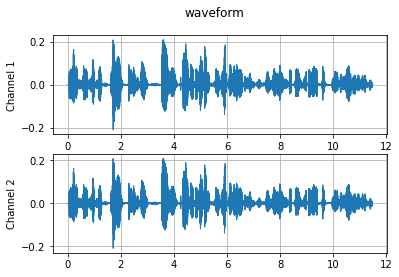

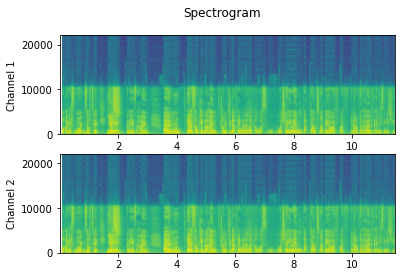

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa
import librosa.display

x, sr = torchaudio.load(mp3_path)

def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)
    
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)

plot_waveform(x, sr)
plot_specgram(x, sr)